# Imports and configs

In [1]:
!pip install -q autogluon.tabular ray==2.10.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.1 requires botocore<1.35.24,>=1.35.16, but you have botocore 1.29.165 which is incompatible.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import pickle
import shutil
import os

warnings.filterwarnings('ignore')

In [3]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e11/train.csv'
    test_path = '/kaggle/input/playground-series-s4e11/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e11/sample_submission.csv'
    original_data_path = '/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv'
    
    target = 'Depression'
    n_folds = 5
    seed = 42
    time_limit = 3600 * 1

# Loading data and defining folds

In [4]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')

original = pd.read_csv(CFG.original_data_path)
original[CFG.target] = original[CFG.target].map({'Yes': 1, 'No': 0})

In [5]:
skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = skf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, 'fold'] = i

# Fitting the predictor

In [6]:
predictor = TabularPredictor(
    problem_type='binary',
    eval_metric='accuracy',
    label=CFG.target,
    groups='fold',
    verbosity=2
)

No path specified. Models will be saved in: "AutogluonModels/ag-20241107_114630"


In [7]:
predictor.fit_pseudolabel(
    train_data=train,
    pseudo_data=original,
    time_limit=CFG.time_limit,
    presets='best_quality',
    excluded_model_types = ["KNN"],
    ag_args_fit={
#         'num_gpus': 1, 
        'num_cpus': 4
    }
)

Predictor not fit prior to pseudolabeling. Fitting now...
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jun 27 20:43:36 UTC 2024
CPU Count:          4
Memory Avail:       30.25 GB / 31.36 GB (96.5%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdou

In [8]:
predictor.leaderboard(silent=True).style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost_BAG_L1,0.940419,accuracy,0.412432,484.657808,0.412432,484.657808,1,True,5
1,WeightedEnsemble_L2,0.940419,accuracy,0.426369,487.983628,0.013937,3.325820,2,True,11
2,CatBoost_BAG_L1_PSEUDO,0.940306,accuracy,0.337129,409.274261,0.337129,409.274261,1,True,16
3,WeightedEnsemble_L2_PSEUDO,0.940306,accuracy,0.350997,414.416992,0.013868,5.142732,2,True,27
4,CatBoost_r177_BAG_L1_PSEUDO,0.940057,accuracy,0.260374,224.345655,0.260374,224.345655,1,True,23
5,LightGBMXT_BAG_L1,0.939979,accuracy,1.729168,53.699404,1.729168,53.699404,1,True,1
6,XGBoost_BAG_L1_PSEUDO,0.939950,accuracy,0.897096,624.762604,0.897096,624.762604,1,True,20
7,LightGBMXT_BAG_L1_PSEUDO,0.939908,accuracy,0.984010,45.596597,0.984010,45.596597,1,True,12
8,XGBoost_BAG_L1,0.939737,accuracy,0.877576,528.862153,0.877576,528.862153,1,True,9
9,LightGBM_BAG_L1_PSEUDO,0.939240,accuracy,0.586397,34.499086,0.586397,34.499086,1,True,13


In [9]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

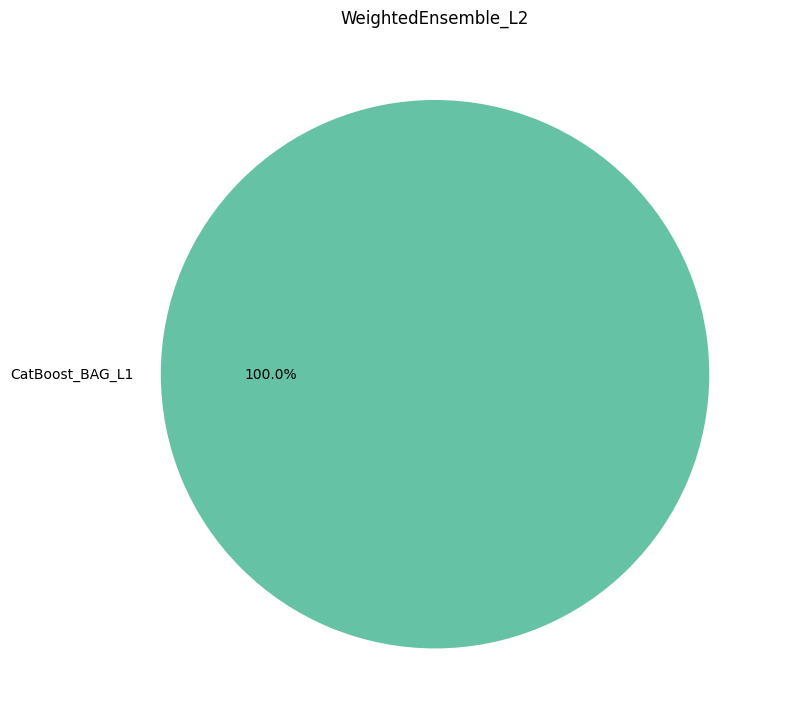

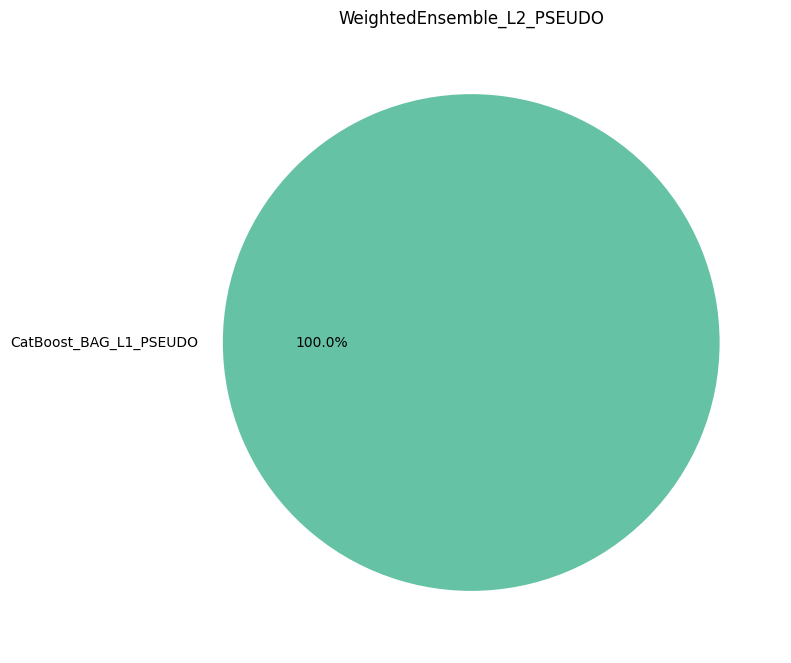

In [10]:
ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(8, 8))
    plt.pie(value.values(), labels=value.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

# Saving OOF files and creating a submission file

In [11]:
def save_pred_probs(pred_probs, cv_score, name, type, is_ensemble):
    base_path = 'oof_pred_probs' if type == 'oof' else 'test_pred_probs'
    base_path = '.' if is_ensemble else base_path
    with open(f'{base_path}/{name}_{type}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)

def save_submission(test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs.round().astype(int)
    sub.to_csv(f'sub_autogluon_{score:.6f}.csv', index=False)
    
os.makedirs('oof_pred_probs', exist_ok=True)
os.makedirs('test_pred_probs', exist_ok=True)

In [12]:
oof_pred_probs = {}
test_pred_probs = {}

In [13]:
best_model = predictor.model_best
test_pred_probs = predictor.predict_proba_multi(test)
for model in predictor.model_names():
    model_oof_pred_probs = predictor.predict_proba_oof(model).values[:, 1]
    model_test_pred_probs = test_pred_probs[model].values[:, 1]
    
    cv_score = accuracy_score(train[CFG.target], model_oof_pred_probs.round())
    if model != best_model:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', False)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', False)
    else:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', True)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', True)
        save_submission(model_test_pred_probs, cv_score)
        
    oof_pred_probs[model] = model_oof_pred_probs
    test_pred_probs[model] = model_test_pred_probs

# Visualizing the results

In [14]:
scores = {}
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = accuracy_score(train.loc[val_index, CFG.target], oof_pred_probs[model][val_index].round())
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

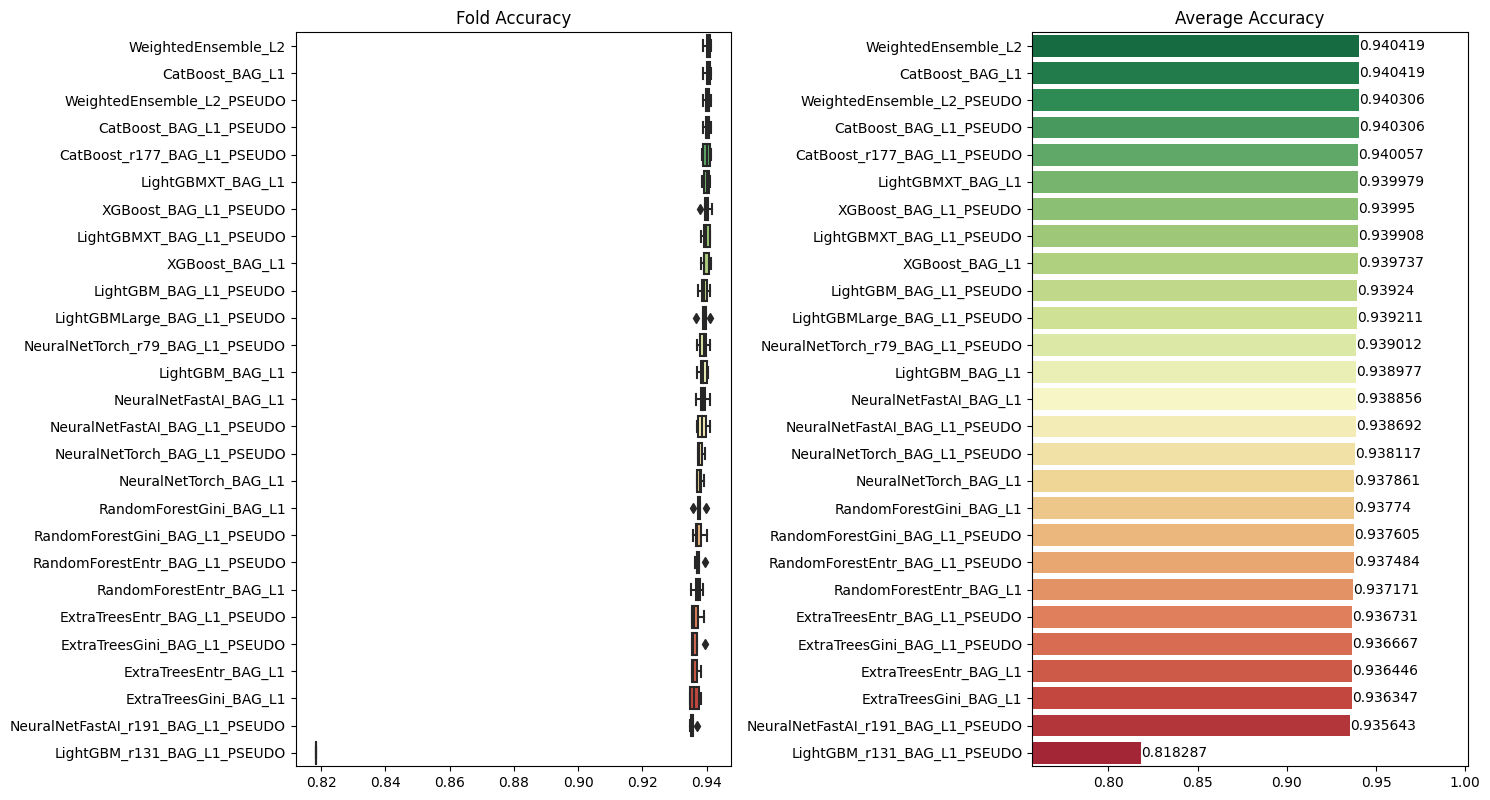

In [15]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold Accuracy')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average Accuracy')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()

In [16]:
shutil.rmtree("AutogluonModels")